# TESLA STOCKS ANALYSIS AND PREDICTION

In this project, I have analysed tesla stocks from January 2021 till December 2023. The data has been gathered using YFinance API. This API offers various daily updated stock datasets. I have used python YFinance library for fetching the dataset but you can also go to their website "https://finance.yahoo.com/" and get required data.

Furthermore, I have predicted the values for the month of January using 2 approached. First approach is using LSTM regression model and second approach is combining LSTM model along with Simple RNN model and predict the future stock prices.

In [1]:
# !pip install yfinance
!pip install --user statsmodels


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [64]:
import yfinance as yf
import matplotlib.pyplot as plt

# Fetch Tesla stock data
tesla = yf.Ticker("TSLA")

# Get historical data (adjust the start and end dates as needed)
df = tesla.history(start="2021-01-01", end="2024-01-01")


In [65]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-04 00:00:00-05:00,239.820007,248.163330,239.063339,243.256668,145914600,0.0,0.0
2021-01-05 00:00:00-05:00,241.220001,246.946671,239.733337,245.036667,96735600,0.0,0.0
2021-01-06 00:00:00-05:00,252.830002,258.000000,249.699997,251.993332,134100000,0.0,0.0
2021-01-07 00:00:00-05:00,259.209991,272.329987,258.399994,272.013336,154496700,0.0,0.0
2021-01-08 00:00:00-05:00,285.333344,294.829987,279.463318,293.339996,225166500,0.0,0.0


In [66]:
print(df.isnull().sum())

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


In [67]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)


# Time Series Plot

In this plot, closing prices of the stocks are observed over a period of time. It seemed that TESLA stocks have faced extreme diversions throughout the time. Nonetheless, stock prices are decreased by the end of December.

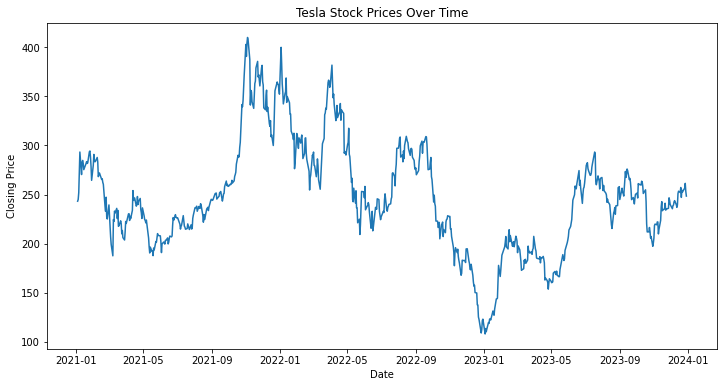

In [68]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Tesla Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Tesla Stock Prices Over Time')
plt.show()

# Trend Analysis using Simple Moving Average

Looking at the moving averages of stock, we can see that stocks see high variations on a short term basis (30 days), but after considering a wider perspective (100 or 200 days) stocks were relatively stable. Although, stock prices have faced a massive decline in the year 2023. Even when considering long term investments we can see that by the end of 2023 stocks have still not entirely touched their maximum price as they were in the beginning of 2023. Also, from November 2023 to December 2023 they have faced a slight decline in the market. Overall analysis suggests that it is riskier to invest in these stocks and also not a good time to invest presently since the stock prices can possibly decline.

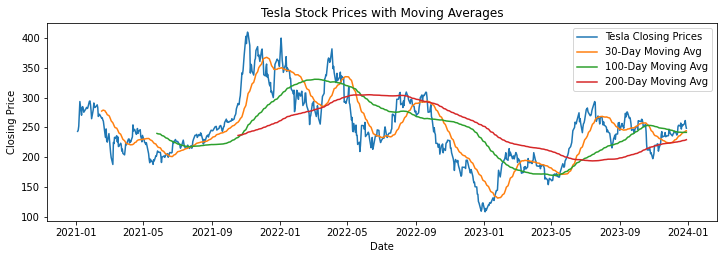

In [69]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(df.index, df['Close'], label='Tesla Closing Prices')
plt.plot(df.index, df['Close'].rolling(window=30).mean(), label='30-Day Moving Avg')
plt.plot(df.index, df['Close'].rolling(window=100).mean(), label='100-Day Moving Avg')
plt.plot(df.index, df['Close'].rolling(window=200).mean(), label='200-Day Moving Avg')

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Tesla Stock Prices with Moving Averages')
plt.legend()
plt.show()


# Volatility Analysis with Bollinger Bands:

Higher diversion in volatility indicates higher chances of future fluctuations in stock prices. If we see whether it be on a long run or a short run, price diversion was always high. Particularly, in the recent times, prices were dramatically declined.

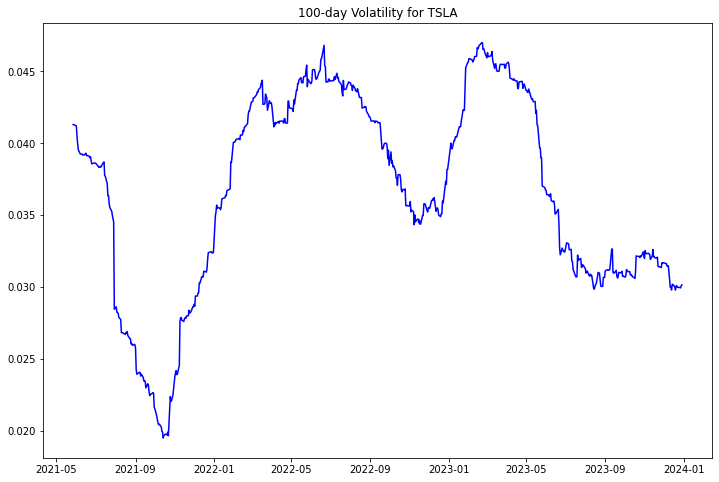

In [70]:
# Calculate daily returns
df['Daily_Returns'] = df['Close'].pct_change()

# Calculate 100-day volatility (standard deviation of returns)
volatility = df['Daily_Returns'].rolling(window=100).std()

# Plotting the volatility
plt.figure(figsize=(12, 8))
plt.plot(volatility, color='blue')
plt.title(f'100-day Volatility for TSLA')
plt.show()

# Seasonality Analysis

When seasonal trend was observed on a monthly basis, a gradual decrease was seen in stock prices.

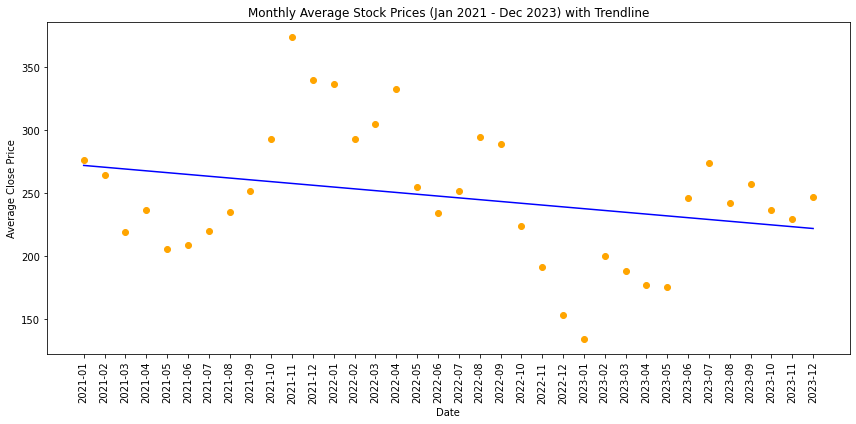

In [103]:
import seaborn as sns

# Resample the data to get monthly averages
monthly_avg = data['Close'].resample('M').mean()

# Extracting month and year for scatter plot
monthly_avg.index = monthly_avg.index.strftime('%Y-%m')

# Creating x and y values for the trendline
x_values = np.arange(len(monthly_avg))
y_values = monthly_avg.values

# Calculate linear regression (trendline)
coefficients = np.polyfit(x_values, y_values, 1)
trendline = coefficients[0] * x_values + coefficients[1]

# Plotting the scatter plot of monthly average stock prices with trendline
plt.figure(figsize=(12, 6))
plt.scatter(monthly_avg.index, monthly_avg.values, color='orange', label='Monthly Avg Prices')
plt.plot(monthly_avg.index, trendline, color='blue', label='Trendline')
plt.title(f'Monthly Average Stock Prices (Jan 2021 - Dec 2023) with Trendline')
plt.xlabel('Date')
plt.ylabel('Average Close Price')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Predict prices for the month of January 2024 based on the historical data

I have used LSTM model to predict the future prices for Tesla stocks. The reason I have used LSTM model is because of the ability of these model to capture long-term dependencies in sequential data. LSTMs have a memory cell that can maintain information for an extended period, allowing them to remember patterns or trends in historical stock prices. Since stock market data is generally unstable with highly fluctuating prices, LSTMs can do well with such data. They can handle various input types (e.g., multiple features like volume, opening price, etc.) and can predict a single value (next-day price) or multiple steps ahead.

In [113]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import datetime, timedelta


# Extract the 'Close' prices
data = df['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Prepare the dataset
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_steps = 60  # Number of time steps to consider for prediction
X, y = create_dataset(scaled_data, time_step=time_steps)

# Reshape data for LSTM (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(X, y, epochs=100, batch_size=32)

# Predicting the next month stock prices
last_month = scaled_data[-time_steps:]
last_month = last_month.reshape(1, time_steps, 1)

predicted_prices = []
for i in range(30):  # Predicting 30 days (1 month) ahead
    prediction = model.predict(last_month)
    predicted_prices.append(prediction[0, 0])
    last_month = np.append(last_month[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# Inverse transform the predicted prices to original scale
predicted_prices = np.array(predicted_prices).reshape(-1, 1)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Generate dates for the next month
last_date = df.index[-1]  # Assuming the index contains date information
predicted_dates = [last_date + pd.DateOffset(days=i) for i in range(1, 31)]

# Create a DataFrame for predicted prices and dates
predicted_df = pd.DataFrame({'Date': predicted_dates, 'Predicted Close': predicted_prices.flatten()})
print(predicted_df)



Epoch 1/100
22/22 [==============================] - 6s 51ms/step - loss: 0.0508
Epoch 2/100
22/22 [==============================] - 1s 52ms/step - loss: 0.0085
Epoch 3/100
22/22 [==============================] - 1s 52ms/step - loss: 0.0058
Epoch 4/100
22/22 [==============================] - 1s 52ms/step - loss: 0.0049
Epoch 5/100
22/22 [==============================] - 1s 51ms/step - loss: 0.0044
Epoch 6/100
22/22 [==============================] - 1s 52ms/step - loss: 0.0040
Epoch 7/100
22/22 [==============================] - 1s 53ms/step - loss: 0.0038
Epoch 8/100
22/22 [==============================] - 1s 55ms/step - loss: 0.0035
Epoch 9/100
22/22 [==============================] - 1s 53ms/step - loss: 0.0034
Epoch 10/100
22/22 [==============================] - 1s 53ms/step - loss: 0.0032
Epoch 11/100
22/22 [==============================] - 1s 52ms/step - loss: 0.0030
Epoch 12/100
22/22 [==============================] - 1s 50ms/step - loss: 0.0029
Epoch 13/100
22/22 [=====

1/1 [==============================] - 0s 40ms/step
                        Date  Predicted Close
0  2023-12-30 00:00:00-05:00       246.587448
1  2023-12-31 00:00:00-05:00       244.537048
2  2024-01-01 00:00:00-05:00       242.426132
3  2024-01-02 00:00:00-05:00       240.024155
4  2024-01-03 00:00:00-05:00       237.546432
5  2024-01-04 00:00:00-05:00       235.078964
6  2024-01-05 00:00:00-05:00       232.653717
7  2024-01-06 00:00:00-05:00       230.289978
8  2024-01-07 00:00:00-05:00       227.998978
9  2024-01-08 00:00:00-05:00       225.785461
10 2024-01-09 00:00:00-05:00       223.650085
11 2024-01-10 00:00:00-05:00       221.591080
12 2024-01-11 00:00:00-05:00       219.605316
13 2024-01-12 00:00:00-05:00       217.688919
14 2024-01-13 00:00:00-05:00       215.837753
15 2024-01-14 00:00:00-05:00       214.047775
16 2024-01-15 00:00:00-05:00       212.315247
17 2024-01-16 00:00:00-05:00       210.636627
18 2024-01-17 00:00:00-05:00       209.008835
19 2024-01-18 00:00:00-05:00

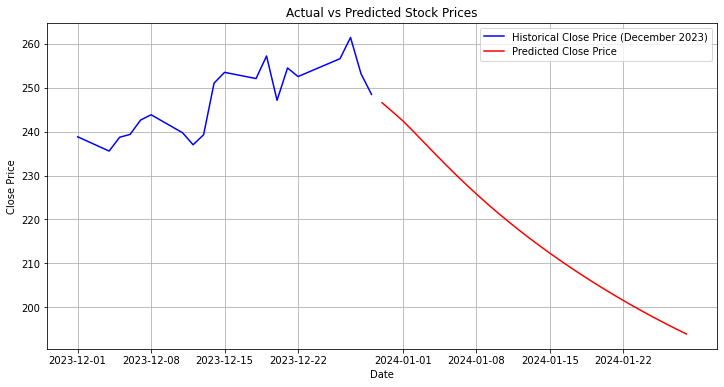

In [116]:
# Filter historical data for December 2023
december_2023_data = df[(df.index.month == 12) & (df.index.year == 2023)]

# Plotting the historical data for December 2023
plt.figure(figsize=(12, 6))
plt.plot(december_2023_data.index, december_2023_data['Close'], label='Historical Close Price (December 2023)', color='blue')
# Plotting the predicted prices for the next month
plt.plot(predicted_df['Date'], predicted_df['Predicted Close'], label='Predicted Close Price', color='red')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


# Finding Percent Difference in the predicted prices for the month of January 2024

A whopping difference of -21.35% is obtained after performing calculations for predicted prices.

In [127]:
if not predicted_df.empty:
    # Calculate percent change
    predicted_prices_jan_2023 = predicted_df['Predicted Close'].values
    percent_change_jan_2023 = ((predicted_prices_jan_2023[-1] - predicted_prices_jan_2023[0]) / predicted_prices_jan_2023[0]) * 100

    print(f"Predicted percent change for January 2023: {percent_change_jan_2023:.2f}%")
else:
    print("No data available for January 2023 in the predictions.")


Predicted percent change for January 2023: -21.35%
